# **ONLY YEAR 2017, Replica of RUSBoost previous work**

## Python Environment

### Import Python libraries

In [1]:
# Data libraries
#from google.colab import drive
import os
import pandas as pd
import calendar
import numpy as np
import gc
import math
from operator import itemgetter

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from seaborn import violinplot, boxenplot

# Model training
from sklearn.model_selection import cross_validate
from sklearn import metrics, preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
#from imblearn.ensemble import RUSBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import base
import joblib
    # Keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Lambda
    # Tensorflow
import tensorflow as tf

# Statistical tests
from scipy.stats import shapiro

### SET ENVIRONMENT VARIABLES

In [2]:
# WORKING FOLDER: /content/local/Traffic/data or /content/drive/MyDrive/Traffic/data
ROOT = '/content/local/Traffic/data'
# PREDICTION HORIZON
PREDICTED_MINUTES_AHEAD = 5
if (PREDICTED_MINUTES_AHEAD%5 != 0): raise ValueError("Invalid prediction horizon. Must be multiple of 5 minutes")
INPUT_MINUTES_BEFORE = 45
if (INPUT_MINUTES_BEFORE%5 != 0): raise ValueError("Invalid input minutes span. Must be multiple of 5 minutes")

# **LOAD DATA**

## DATA [ LINK_ID, TT_ARR, LOS_DEP ] (Year 2017)

In [3]:


training_mon = []
training_week = []
training_fri = []
training_weeknd = []

directory = '/content/drive/MyDrive/Traffic/data/processed/'
for filename in os.listdir(directory):
    if "2017" not in filename:
        continue
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set contains all data
    X = df[['link_id', 'tt_arr']]
    for weekday in range(0,7):
        # Mon
        if weekday == 0:
            training_mon.append( pd.merge(X, Y[(Y.index.weekday == weekday)], on=['date', 'link_id'], how='inner') )
        # Tue-Wed-Thu
        elif weekday in [1,2,3]:
            training_week.append( pd.merge(X, Y[(Y.index.weekday == weekday)], on=['date', 'link_id'], how='inner') )
        elif weekday == 4:
            training_fri.append( pd.merge(X, Y[(Y.index.weekday == weekday)], on=['date', 'link_id'], how='inner') )
        elif weekday in [5,6]:
            training_weeknd.append( pd.merge(X, Y[(Y.index.weekday == weekday)], on=['date', 'link_id'], how='inner') )

del df,X,Y
training_df_mon = pd.concat(training_mon)
training_df_week = pd.concat(training_week)
training_df_fri = pd.concat(training_fri)
training_df_weeknd = pd.concat(training_weeknd)

del training_mon,training_week,training_fri,training_weeknd

Sevilla_2017.csv 365.0


## DATA [ LINK_ID, TT_ARR, TT_ARR-5, TT_ARR-10, ..., TT_ARR-N, LOS_DEP ] (Year 2017)

In [8]:


training_mon = []
training_week = []
training_fri = []
training_weeknd = []

directory = '/content/drive/MyDrive/Traffic/data/processed/'
for filename in os.listdir(directory):
    if "2017" not in filename:
        continue
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df[['link_id', 'tt_arr']]
    for offset in range(1,int((INPUT_MINUTES_BEFORE)/5)+1):
        X = pd.merge(X, df.shift(offset*5, freq='min')[['link_id', 'tt_arr']], on=['date', 'link_id'], how='inner', suffixes=[None, f'-{int(offset*5)}'])
    for weekday in range(0,7):
        # Mon
        if weekday == 0:
            training_mon.append( pd.merge(X, Y[(Y.index.weekday == weekday)], on=['date', 'link_id'], how='inner') )
        # Tue-Wed-Thu
        elif weekday in [1,2,3]:
            training_week.append( pd.merge(X, Y[(Y.index.weekday == weekday)], on=['date', 'link_id'], how='inner') )
        elif weekday == 4:
            training_fri.append( pd.merge(X, Y[(Y.index.weekday == weekday)], on=['date', 'link_id'], how='inner') )
        elif weekday in [5,6]:
            training_weeknd.append( pd.merge(X, Y[(Y.index.weekday == weekday)], on=['date', 'link_id'], how='inner') )

del df,X,Y
training_df_mon = pd.concat(training_mon)
training_df_week = pd.concat(training_week)
training_df_fri = pd.concat(training_fri)
training_df_weeknd = pd.concat(training_weeknd)

del training_mon,training_week,training_fri,training_weeknd

Sevilla_2017.csv 365.0


# DATA EXPLORATION

> Per weekday link LOS histogram


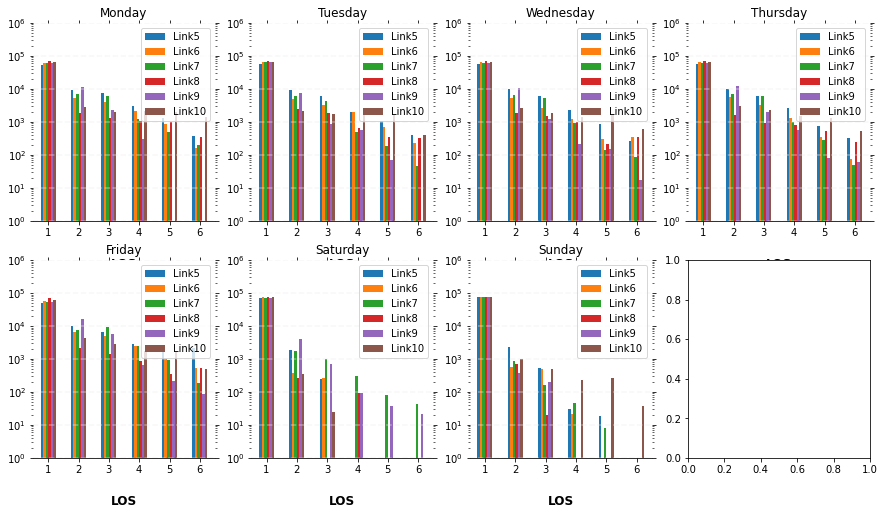

In [23]:
dias_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(nrows=2, ncols=4)
for weekday in range(0,7):
    plot_df = pd.DataFrame(index=[i for i in range(1,7)])
    for LINK in range(5,11):
        plot_df[f'Link{LINK}'] = df[(df['link_id']==LINK) & (df.index.weekday == weekday)].groupby('LOS_dep')['tt_arr'].count()
    plot_df.fillna(0)
    
    plot_df.plot.bar(ax=axes[math.floor(weekday/4),weekday%4], rot=0, figsize=(15,8), log=True)
    # Set title
    axes[math.floor(weekday/4),weekday%4].set_title(f'{dias_semana[weekday]}')

for x_col in axes:
    for x in x_col:
        if x.get_title() != '':
            # Despine
            x.spines['right'].set_visible(False)
            x.spines['top'].set_visible(False)
            x.spines['left'].set_visible(False)

            # Switch off ticks
            x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

            # Draw horizontal axis lines
            vals = x.get_yticks()
            for tick in vals:
                x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

            # Set y-lim
            x.set_ylim(top=1e6)

            # Set x-axis label
            x.set_xlabel(f"LOS", labelpad=20, weight='bold', size=12)

# **RUSBoost**

### *Algorithms*

**Algorithm implementation M2**

In [4]:
def labelToIndex(cl,clf):
    return clf.labelDict[cl]

def indexToLabel(i,clf):
    return clf.classes[i]

class RUSBoostClassifier_(base.BaseEstimator):
    
    def __init__(self,base_estimator=None,n_estimators=50,learning_rate=1.0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        if base_estimator == None:
            base_estimator = DecisionTreeClassifier(max_depth=1)
        self.base_estimator = base_estimator
        self.estimator_errors_ = []
        self.observation_weights_ = {}
        
    def classes_(self):
        return self.classes

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        """
        param X: DataFrame that contains the features with shape (n_samples, )
        param y: DataFrame with the labels
        """        
        
        # Class labels mapping to indices
        self.createLabelDict(np.unique(y))
        k = len(self.classes)
        # `undersampling_n` elements to sample from each class, equal #samples minority class
        undersampling_n = min(y.value_counts())

        # Initialize observation weights as 1/(N*(k-1)) where N is total `n_samples` and k is the numebr of classes
        N = X.shape[0]
        B = N*(k-1)
        D = {epoch: np.full(k-1,1/B) for epoch in X.index}

        # Get whole dataset samples to later calculate the weighting factors on every iteration
        iTL = np.vectorize(labelToIndex)
        y_indices = iTL(y.values,self)
        
        # M iterations (#WeakLearners)
        for m in range(self.n_estimators):

        # 1) Random UnderSampling
            df_ = pd.DataFrame()
            for label_ in self.classes:
                df_ = pd.concat([ df_, X.loc[y==label_].sample(undersampling_n, replace=False) ])

            
            # Training data initalization
            X_ = df_.values
            y_ = y.loc[df_.index].values
            D_ = np.sum([D[epoch] for epoch in df_.index], axis=-1)

        # 2) WeakLearner training
            Gm = base.clone(self.base_estimator).\
                            fit(X_,y_,sample_weight=D_).predict_proba
            self.models.append(Gm)
        
        # 3) Error-rate computation
            predictions_proba = Gm(X.values)
            sum_pseudolosses = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        sum_pseudolosses += D[epoch][k_index]*(1-predictions_proba[i,y_indices[i]]+predictions_proba[i,cl])
                        k_index += 1

            error = 0.5 * sum_pseudolosses
            self.estimator_errors_.append(error)
        
        # 4) WeakLearner weight for ensemble computation
            BetaM = error/(1-error)
            self.models[m] = (BetaM,Gm)

        # 5) Observation weights update for next iteration with weights normalization
            norm_ = 0
            for i, epoch in enumerate(D.keys()):
                k_index = 0
                for cl in range(k):
                    if cl != y_indices[i]:
                        w_ = 0.5*(1+predictions_proba[i,y_indices[i]]-predictions_proba[i,cl])
                        D[epoch][k_index] *= BetaM**(self.learning_rate*w_)
                        norm_ += D[epoch][k_index]
                        k_index += 1
            for epoch in D.keys():
                D[epoch] /= norm_
        
        self.observation_weights_ = D
        
        return self
            
    def createLabelDict(self,classes):
        self.labelDict = {}
        self.classes = classes
        for i,cl in enumerate(classes):
            self.labelDict[cl] = i
    
    def predict(self,X):
        sum_model_hypothesis = np.sum(np.stack([-np.log(Bm)*Gm(X) for Bm,Gm in self.models], axis=-1), axis=-1)
        iTL = np.vectorize(indexToLabel)            
        return iTL(np.argmax(sum_model_hypothesis,axis=1),self)


### **NO FEATURE ENGINEERING M2**

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")

    features_name = 'tt_arr$'

    print(f"MONDAY")
    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=128+1), n_estimators=30, learning_rate=0.3)
    X = training_df_mon[training_df_mon['link_id'] == LINK].filter(regex=(features_name))
    y = training_df_mon[training_df_mon['link_id'] == LINK]['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")
    
    print(f"TUESDAY-WEDNESDAY-THURSDAY")
    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=196+1), n_estimators=30, learning_rate=0.3)
    X = training_df_week[training_df_week['link_id'] == LINK].filter(regex=(features_name))
    y = training_df_week[training_df_week['link_id'] == LINK]['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")

    print(f"FRIDAY")
    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=128+1), n_estimators=30, learning_rate=0.3)
    X = training_df_fri[training_df_fri['link_id'] == LINK].filter(regex=(features_name))
    y = training_df_fri[training_df_fri['link_id'] == LINK]['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")

    print(f"WEEKEND")
    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=128+1), n_estimators=30, learning_rate=0.3)
    X = training_df_weeknd[training_df_weeknd['link_id'] == LINK].filter(regex=(features_name))
    y = training_df_weeknd[training_df_weeknd['link_id'] == LINK]['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")

LINK 5
MONDAY


	LOS 1: Recall 86.99%
	LOS 2: Recall 36.35%
	LOS 3: Recall 36.23%
	LOS 4: Recall 31.27%
	LOS 5: Recall 35.2%
	LOS 6: Recall 38.43%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 85.57%
	LOS 2: Recall 54.49%
	LOS 3: Recall 36.97%
	LOS 4: Recall 36.14%
	LOS 5: Recall 28.52%
	LOS 6: Recall 36.52%
FRIDAY


	LOS 1: Recall 85.42%
	LOS 2: Recall 41.54%
	LOS 3: Recall 35.65%
	LOS 4: Recall 29.98%
	LOS 5: Recall 30.61%
	LOS 6: Recall 54.04%
WEEKEND


	LOS 1: Recall 95.62%
	LOS 2: Recall 71.76%
	LOS 3: Recall 75.02%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 6
MONDAY


	LOS 1: Recall 84.21%
	LOS 2: Recall 57.57%
	LOS 3: Recall 27.5%
	LOS 4: Recall 36.43%
	LOS 5: Recall 39.48%
	LOS 6: Recall 24.21%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 82.52%
	LOS 2: Recall 54.6%
	LOS 3: Recall 32.32%
	LOS 4: Recall 38.51%
	LOS 5: Recall 18.96%
	LOS 6: Recall 55.5%
FRIDAY


	LOS 1: Recall 85.62%
	LOS 2: Recall 48.72%
	LOS 3: Recall 35.13%
	LOS 4: Recall 29.93%
	LOS 5: Recall 23.4%
	LOS 6: Recall 29.5%
WEEKEND


	LOS 1: Recall 97.53%
	LOS 2: Recall 68.79%
	LOS 3: Recall 62.28%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 7
MONDAY


	LOS 1: Recall 89.04%
	LOS 2: Recall 47.98%
	LOS 3: Recall 40.72%
	LOS 4: Recall 27.72%
	LOS 5: Recall 27.01%
	LOS 6: Recall 44.53%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 88.59%
	LOS 2: Recall 47.11%
	LOS 3: Recall 51.08%
	LOS 4: Recall 30.64%
	LOS 5: Recall 40.55%
	LOS 6: Recall 21.99%
FRIDAY


	LOS 1: Recall 88.34%
	LOS 2: Recall 45.82%
	LOS 3: Recall 40.07%
	LOS 4: Recall 33.18%
	LOS 5: Recall 29.17%
	LOS 6: Recall 2.8%
WEEKEND


	LOS 1: Recall 94.27%
	LOS 2: Recall 52.7%
	LOS 3: Recall 47.62%
	LOS 4: Recall 29.64%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
MONDAY


	LOS 1: Recall 93.26%
	LOS 2: Recall 49.6%
	LOS 3: Recall 20.66%
	LOS 4: Recall 35.23%
	LOS 5: Recall 16.59%
	LOS 6: Recall 24.44%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 93.56%
	LOS 2: Recall 48.4%
	LOS 3: Recall 40.53%
	LOS 4: Recall 20.75%
	LOS 5: Recall 24.71%
	LOS 6: Recall 36.78%
FRIDAY


	LOS 1: Recall 89.72%
	LOS 2: Recall 41.47%
	LOS 3: Recall 24.25%
	LOS 4: Recall 30.75%
	LOS 5: Recall 13.09%
	LOS 6: Recall 32.55%
WEEKEND


	LOS 1: Recall 99.57%
	LOS 2: Recall 76.56%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 9
MONDAY


	LOS 1: Recall 89.31%
	LOS 2: Recall 65.62%
	LOS 3: Recall 54.87%
	LOS 4: Recall 40.03%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 89.68%
	LOS 2: Recall 64.05%
	LOS 3: Recall 52.66%
	LOS 4: Recall 57.89%
	LOS 5: Recall 21.07%
	LOS 6: Recall 75.0%
FRIDAY


	LOS 1: Recall 91.06%
	LOS 2: Recall 66.42%
	LOS 3: Recall 63.34%
	LOS 4: Recall 35.88%
	LOS 5: Recall 44.51%
	LOS 6: Recall 50.95%
WEEKEND


	LOS 1: Recall 96.09%
	LOS 2: Recall 73.11%
	LOS 3: Recall 59.41%
	LOS 4: Recall 54.0%
	LOS 5: Recall 6.67%
	LOS 6: Recall 0.0%
LINK 10
MONDAY


	LOS 1: Recall 85.86%
	LOS 2: Recall 39.81%
	LOS 3: Recall 31.86%
	LOS 4: Recall 23.64%
	LOS 5: Recall 38.56%
	LOS 6: Recall 39.76%
TUESDAY-WEDNESDAY-THURSDAY


### **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

*Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

In [10]:
for LINK in range(5,11):
    print(f"LINK {LINK}")   

    features_name = 'tt_ar[^-]+$'

    print(f"MONDAY")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df_mon.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df_mon[training_df_mon['link_id'] == other_link].filter(regex=(features_name)), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=128+1), n_estimators=30, learning_rate=0.3)
    X = training_df_link.filter(regex=(features_name))
    y = training_df_link['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")
    
    print(f"TUESDAY-WEDNESDAY-THURSDAY")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df_week.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df_week[training_df_week['link_id'] == other_link].filter(regex=(features_name)), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=196+1), n_estimators=30, learning_rate=0.3)
    X = training_df_link.filter(regex=(features_name))
    y = training_df_link['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")

    print(f"FRIDAY")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df_fri.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df_fri[training_df_fri['link_id'] == other_link].filter(regex=(features_name)), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=128+1), n_estimators=30, learning_rate=0.3)
    X = training_df_link.filter(regex=(features_name))
    y = training_df_link['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")

    print(f"WEEKEND")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df_weeknd.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df_weeknd[training_df_weeknd['link_id'] == other_link].filter(regex=(features_name)), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=128+1), n_estimators=30, learning_rate=0.3)
    X = training_df_link.filter(regex=(features_name))
    y = training_df_link['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")

LINK 5
MONDAY


	LOS 1: Recall 87.73%
	LOS 2: Recall 53.64%
	LOS 3: Recall 47.5%
	LOS 4: Recall 31.21%
	LOS 5: Recall 38.63%
	LOS 6: Recall 24.04%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 85.7%
	LOS 2: Recall 58.41%
	LOS 3: Recall 47.28%
	LOS 4: Recall 42.23%
	LOS 5: Recall 35.88%
	LOS 6: Recall 34.37%
FRIDAY


	LOS 1: Recall 86.24%
	LOS 2: Recall 61.32%
	LOS 3: Recall 44.78%
	LOS 4: Recall 41.46%
	LOS 5: Recall 42.89%
	LOS 6: Recall 74.0%
WEEKEND


	LOS 1: Recall 97.64%
	LOS 2: Recall 59.3%
	LOS 3: Recall 65.96%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 6
MONDAY


	LOS 1: Recall 83.62%
	LOS 2: Recall 65.62%
	LOS 3: Recall 28.96%
	LOS 4: Recall 40.49%
	LOS 5: Recall 36.9%
	LOS 6: Recall 0.0%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 83.88%
	LOS 2: Recall 64.31%
	LOS 3: Recall 41.96%
	LOS 4: Recall 54.92%
	LOS 5: Recall 31.42%
	LOS 6: Recall 58.06%
FRIDAY


	LOS 1: Recall 85.55%
	LOS 2: Recall 61.51%
	LOS 3: Recall 39.23%
	LOS 4: Recall 34.06%
	LOS 5: Recall 26.85%
	LOS 6: Recall 41.85%
WEEKEND


	LOS 1: Recall 97.32%
	LOS 2: Recall 77.4%
	LOS 3: Recall 64.39%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 7
MONDAY


	LOS 1: Recall 89.5%
	LOS 2: Recall 58.54%
	LOS 3: Recall 46.52%
	LOS 4: Recall 43.4%
	LOS 5: Recall 35.97%
	LOS 6: Recall 36.55%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 87.66%
	LOS 2: Recall 54.66%
	LOS 3: Recall 53.62%
	LOS 4: Recall 42.87%
	LOS 5: Recall 39.33%
	LOS 6: Recall 25.37%
FRIDAY


	LOS 1: Recall 91.72%
	LOS 2: Recall 55.69%
	LOS 3: Recall 47.61%
	LOS 4: Recall 29.2%
	LOS 5: Recall 22.06%
	LOS 6: Recall 34.98%
WEEKEND


	LOS 1: Recall 95.79%
	LOS 2: Recall 51.23%
	LOS 3: Recall 39.66%
	LOS 4: Recall 18.59%
	LOS 5: Recall 12.45%
	LOS 6: Recall 0.0%
LINK 8
MONDAY


	LOS 1: Recall 95.0%
	LOS 2: Recall 57.61%
	LOS 3: Recall 33.92%
	LOS 4: Recall 39.7%
	LOS 5: Recall 11.75%
	LOS 6: Recall 38.87%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 94.19%
	LOS 2: Recall 58.35%
	LOS 3: Recall 46.2%
	LOS 4: Recall 29.49%
	LOS 5: Recall 24.36%
	LOS 6: Recall 41.64%
FRIDAY


	LOS 1: Recall 92.53%
	LOS 2: Recall 52.44%
	LOS 3: Recall 37.63%
	LOS 4: Recall 37.61%
	LOS 5: Recall 11.77%
	LOS 6: Recall 48.98%
WEEKEND


	LOS 1: Recall 99.66%
	LOS 2: Recall 54.04%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 9
MONDAY


	LOS 1: Recall 90.61%
	LOS 2: Recall 72.55%
	LOS 3: Recall 50.18%
	LOS 4: Recall 57.9%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 89.59%
	LOS 2: Recall 69.95%
	LOS 3: Recall 57.15%
	LOS 4: Recall 58.34%
	LOS 5: Recall 29.26%
	LOS 6: Recall 0.0%
FRIDAY


	LOS 1: Recall 89.76%
	LOS 2: Recall 70.85%
	LOS 3: Recall 67.3%
	LOS 4: Recall 41.82%
	LOS 5: Recall 12.87%
	LOS 6: Recall 50.95%
WEEKEND


	LOS 1: Recall 95.89%
	LOS 2: Recall 75.86%
	LOS 3: Recall 53.02%
	LOS 4: Recall 54.0%
	LOS 5: Recall 6.67%
	LOS 6: Recall 0.0%
LINK 10
MONDAY


	LOS 1: Recall 92.25%
	LOS 2: Recall 51.49%
	LOS 3: Recall 33.0%
	LOS 4: Recall 31.59%
	LOS 5: Recall 48.11%
	LOS 6: Recall 42.41%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 92.99%
	LOS 2: Recall 62.38%
	LOS 3: Recall 45.64%
	LOS 4: Recall 38.47%
	LOS 5: Recall 45.87%
	LOS 6: Recall 39.26%
FRIDAY


	LOS 1: Recall 91.63%
	LOS 2: Recall 65.12%
	LOS 3: Recall 45.21%
	LOS 4: Recall 30.93%
	LOS 5: Recall 45.07%
	LOS 6: Recall 43.61%
WEEKEND


	LOS 1: Recall 96.67%
	LOS 2: Recall 72.53%
	LOS 3: Recall 49.15%
	LOS 4: Recall 63.91%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%


### **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

*Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

In [13]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)

    features_name = "tt_arr.*"

    print(f"MONDAY")
    training_df_link = training_df_mon.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df_mon[training_df_mon['link_id'] == other_link].filter(regex=(features_name)), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=128+1), n_estimators=30, learning_rate=0.3)
    X = training_df_link.filter(regex=(features_name))
    y = training_df_link['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")
    
    print(f"TUESDAY-WEDNESDAY-THURSDAY")
    training_df_link = training_df_week.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df_week[training_df_week['link_id'] == other_link].filter(regex=(features_name)), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=196+1), n_estimators=30, learning_rate=0.3)
    X = training_df_link.filter(regex=(features_name))
    y = training_df_link['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")

    print(f"FRIDAY")
    training_df_link = training_df_fri.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df_fri[training_df_fri['link_id'] == other_link].filter(regex=(features_name)), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=128+1), n_estimators=30, learning_rate=0.3)
    X = training_df_link.filter(regex=(features_name))
    y = training_df_link['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")

    print(f"WEEKEND")
    training_df_link = training_df_weeknd.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df_weeknd[training_df_weeknd['link_id'] == other_link].filter(regex=(features_name)), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])

    model = RUSBoostClassifier_(base_estimator=DecisionTreeClassifier(max_leaf_nodes=128+1), n_estimators=30, learning_rate=0.3)
    X = training_df_link.filter(regex=(features_name))
    y = training_df_link['LOS_dep']
    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(model, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        discard = 0
        score = results[f'test_recall{LOS}']
        for _score in score:
            if _score == 0: discard += 1
        if discard != CV:
            print(f"\tLOS {LOS}: Recall {round(sum(score)/(CV-discard)*100, 2)}%")
        else:
            print(f"\tLOS {LOS}: Recall 0.0%")

LINK 5
MONDAY


	LOS 1: Recall 87.8%
	LOS 2: Recall 54.68%
	LOS 3: Recall 48.83%
	LOS 4: Recall 27.2%
	LOS 5: Recall 36.5%
	LOS 6: Recall 27.02%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 85.96%
	LOS 2: Recall 61.87%
	LOS 3: Recall 48.83%
	LOS 4: Recall 41.17%
	LOS 5: Recall 34.23%
	LOS 6: Recall 25.84%
FRIDAY


	LOS 1: Recall 86.86%
	LOS 2: Recall 64.94%
	LOS 3: Recall 46.23%
	LOS 4: Recall 39.13%
	LOS 5: Recall 43.38%
	LOS 6: Recall 65.93%
WEEKEND


	LOS 1: Recall 97.28%
	LOS 2: Recall 52.81%
	LOS 3: Recall 73.64%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 6
MONDAY


	LOS 1: Recall 84.8%
	LOS 2: Recall 68.0%
	LOS 3: Recall 32.58%
	LOS 4: Recall 44.11%
	LOS 5: Recall 38.88%
	LOS 6: Recall 0.0%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 84.41%
	LOS 2: Recall 65.56%
	LOS 3: Recall 46.45%
	LOS 4: Recall 51.85%
	LOS 5: Recall 29.65%
	LOS 6: Recall 52.85%
FRIDAY


	LOS 1: Recall 84.34%
	LOS 2: Recall 62.91%
	LOS 3: Recall 43.37%
	LOS 4: Recall 36.5%
	LOS 5: Recall 20.5%
	LOS 6: Recall 44.56%
WEEKEND


	LOS 1: Recall 97.82%
	LOS 2: Recall 74.0%
	LOS 3: Recall 81.94%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 7
MONDAY


	LOS 1: Recall 86.69%
	LOS 2: Recall 57.12%
	LOS 3: Recall 48.07%
	LOS 4: Recall 36.88%
	LOS 5: Recall 29.16%
	LOS 6: Recall 12.18%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 87.93%
	LOS 2: Recall 51.32%
	LOS 3: Recall 54.8%
	LOS 4: Recall 44.71%
	LOS 5: Recall 28.91%
	LOS 6: Recall 22.06%
FRIDAY


	LOS 1: Recall 91.66%
	LOS 2: Recall 51.96%
	LOS 3: Recall 49.67%
	LOS 4: Recall 38.25%
	LOS 5: Recall 29.67%
	LOS 6: Recall 33.68%
WEEKEND


	LOS 1: Recall 96.87%
	LOS 2: Recall 51.26%
	LOS 3: Recall 31.68%
	LOS 4: Recall 30.13%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 8
MONDAY


	LOS 1: Recall 95.17%
	LOS 2: Recall 59.4%
	LOS 3: Recall 32.68%
	LOS 4: Recall 43.03%
	LOS 5: Recall 10.21%
	LOS 6: Recall 44.56%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 94.93%
	LOS 2: Recall 59.19%
	LOS 3: Recall 49.3%
	LOS 4: Recall 35.9%
	LOS 5: Recall 17.36%
	LOS 6: Recall 37.94%
FRIDAY


	LOS 1: Recall 93.54%
	LOS 2: Recall 57.84%
	LOS 3: Recall 31.93%
	LOS 4: Recall 26.26%
	LOS 5: Recall 14.12%
	LOS 6: Recall 33.04%
WEEKEND


	LOS 1: Recall 99.67%
	LOS 2: Recall 62.94%
	LOS 3: Recall 0.0%
	LOS 4: Recall 0.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 9
MONDAY


	LOS 1: Recall 91.12%
	LOS 2: Recall 72.96%
	LOS 3: Recall 56.67%
	LOS 4: Recall 27.93%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 88.3%
	LOS 2: Recall 69.93%
	LOS 3: Recall 55.5%
	LOS 4: Recall 53.31%
	LOS 5: Recall 19.72%
	LOS 6: Recall 36.59%
FRIDAY


	LOS 1: Recall 90.32%
	LOS 2: Recall 66.82%
	LOS 3: Recall 64.41%
	LOS 4: Recall 33.56%
	LOS 5: Recall 30.0%
	LOS 6: Recall 53.68%
WEEKEND


	LOS 1: Recall 94.48%
	LOS 2: Recall 69.02%
	LOS 3: Recall 39.65%
	LOS 4: Recall 30.0%
	LOS 5: Recall 0.0%
	LOS 6: Recall 0.0%
LINK 10
MONDAY


	LOS 1: Recall 94.31%
	LOS 2: Recall 51.93%
	LOS 3: Recall 39.88%
	LOS 4: Recall 38.46%
	LOS 5: Recall 51.96%
	LOS 6: Recall 45.12%
TUESDAY-WEDNESDAY-THURSDAY


	LOS 1: Recall 93.76%
	LOS 2: Recall 62.25%
	LOS 3: Recall 48.65%
	LOS 4: Recall 42.05%
	LOS 5: Recall 53.84%
	LOS 6: Recall 41.75%
FRIDAY


	LOS 1: Recall 91.87%
	LOS 2: Recall 65.97%
	LOS 3: Recall 50.22%
	LOS 4: Recall 34.35%
	LOS 5: Recall 49.5%
	LOS 6: Recall 44.52%
WEEKEND


	LOS 1: Recall 96.27%
	LOS 2: Recall 78.41%
	LOS 3: Recall 59.91%
	LOS 4: Recall 85.52%
	LOS 5: Recall 43.68%
	LOS 6: Recall 0.0%
